In [12]:
import torch
from torch import nn
from days.w1d4 import w1d4_tests
import matplotlib.pyplot as plt

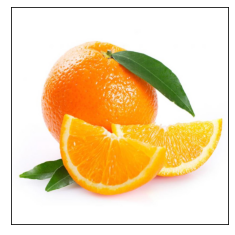

In [170]:
fname = "orange.jpg"
w1d4_tests.plot_image(fname)

In [333]:
data_train, data_test = w1d4_tests.load_image(fname)

In [172]:
class TestModule(nn.Module):

    def __init__(self, P, H, K):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(P, H), 
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, K)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [173]:
w1d4_tests.test_mlp(TestModule)

Congrats! You've passed the test.


In [174]:
def train(model, dataloader, lr, momentum=0):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.L1Loss()
    for X, labels in dataloader:
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
    return model

In [175]:
w1d4_tests.test_train(train)

Congrats! You've passed the test.


In [176]:
def evaluate(model, dataloader):
    with torch.no_grad():
        averages = 0
        loss_fn = nn.L1Loss()
        for X, labels in dataloader:
            output = model(X)
            averages += loss_fn(output, labels)
        return averages / len(dataloader)

In [177]:
w1d4_tests.test_evaluate(evaluate)

Congrats! You've passed the test.


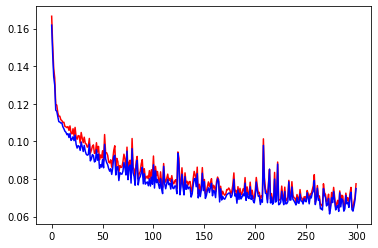

In [178]:
model = TestModule(2, 400, 3)
losses_train = []
losses_test = []
for epoch in range(300):
    model = train(model, data_train, lr=0.01, momentum=0.9)
    loss = evaluate(model, data_train)
    losses_train.append(loss)
    loss = evaluate(model, data_test)
    losses_test.append(loss)


plt.plot(losses_test, 'red')
plt.plot(losses_train, 'blue')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


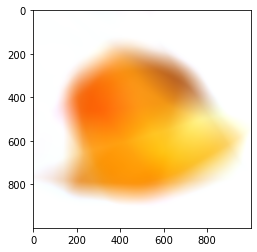

In [179]:
from tqdm.notebook import tqdm, trange
import time
import einops 

def display_image(model, height, width):
    xs = einops.repeat(torch.arange(height), 'h -> h w', w = width)/height - 0.5
    ys = einops.repeat(torch.arange(width), 'w -> h w', h = height)/width - 0.5
    coords = torch.stack((xs,ys), dim = 2)
    img = model(coords) + 0.5
    plt.imshow(img.detach().numpy()) 
    return img, coords


img, coords = display_image(model, 1000, 1000)


In [180]:
def f(x, y, a=1, b=100):
    return (a-x)**2 + b*(y-x**2)**2 + 1

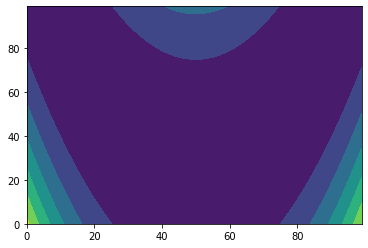

In [185]:

z = [[f(x/25-2, y/25-1) for x in range(100)] for y in range(100)]
plt.contourf(z)

In [191]:
def opt_rosenbrock(optimizer, xy, n_iter):
    losses = torch.zeros(n_iter+1, 2)
    losses[0] = xy
    xy.requires_grad_()
    for epoch in range(n_iter):
        optimizer.zero_grad()
        loss = f(*xy)
        loss.backward()
        optimizer.step()
        losses[epoch+1] = xy
    return torch.Tensor(losses)
    


tensor([[-1.2000,  2.5000],
        [-1.9566,  2.1820],
        [-0.0151,  2.6759],
        ...,
        [ 0.9992,  0.9983],
        [ 0.9992,  0.9983],
        [ 0.9992,  0.9983]], grad_fn=<AliasBackward0>)


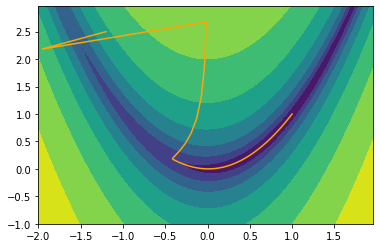

In [232]:
points = opt_rosenbrock(torch.Tensor([-1.2, 2.5]), lr=0.0015, momentum=0.5, n_iter=10000)
import math
z = [[math.log(f(x/25-2, y/25-1)) for x in range(100)] for y in range(100)]
X = [x/25-2 for x in range(100)]
Y = [y/25-1 for y in range(100)]
plt.contourf(X,Y,z)
plt.plot(points[:,0].detach().numpy(), points[:,1].detach().numpy(), 'orange')
print(points)

In [283]:
class SGD:
    def __init__(self, params, lr, momentum, dampening, weight_decay):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.dampening = dampening
        self.weight_decay = weight_decay
        self.cum_grads = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def zero_grad(self):
        for param in self.params:
            param.grad = None

    
    def step(self):
        with torch.no_grad():
            for i in range(len(self.params)):
                assert self.params[i].grad is not None
                g = self.params[i].grad + self.weight_decay * self.params[i]
                if self.momentum != 0:
                    if self.t:
                        self.cum_grads[i] = self.momentum * self.cum_grads[i] + (1 - self.dampening) * g
                    else:
                        self.cum_grads[i] = g
                    g = self.cum_grads[i]
                self.params[i] -= self.lr * g
            self.t += 1
        

w1d4_tests.test_sgd(SGD)



Testing configuration:  {'lr': 0.1, 'momentum': 0.0, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.7, 'dampening': 0.0, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'momentum': 0.5, 'dampening': 0.5, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'momentum': 0.8, 'dampening': 0.0, 'weight_decay': 0.05}
Congrats! You've passed the test.


In [287]:
class RMSprop:
    def __init__(self,params,lr,alpha,eps,weight_decay,momentum):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.weight_decay = weight_decay
        self.momentum = momentum
        self.var = [torch.zeros_like(p) for p in self.params]
        self.cum_grads = [torch.zeros_like(p) for p in self.params]
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None

    
    def step(self):
        with torch.no_grad():
            for i in range(len(self.params)):
                assert self.params[i].grad is not None
                g = self.params[i].grad + self.weight_decay * self.params[i]
                self.var[i] = self.alpha * self.var[i] + (1-self.alpha)*g*g    
                self.cum_grads[i] = self.momentum * self.cum_grads[i] + g/(torch.sqrt(self.var[i])+self.eps)
                self.params[i] -= self.lr * self.cum_grads[i]
    
w1d4_tests.test_rmsprop(RMSprop)


Testing configuration:  {'lr': 0.1, 'alpha': 0.9, 'eps': 0.001, 'weight_decay': 0.0, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.5}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'alpha': 0.95, 'eps': 0.0001, 'weight_decay': 0.05, 'momentum': 0.0}
Congrats! You've passed the test.


In [288]:
class ADAM:
    def __init__(self,params,lr,betas,eps,weight_decay):
        self.params = list(params)
        self.lr = lr
        self.eps = eps
        self.weight_decay = weight_decay
        self.betas = betas
        self.var = [torch.zeros_like(p) for p in self.params]
        self.m = [torch.zeros_like(p) for p in self.params]
        self.t = 1
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None

    
    def step(self):
        with torch.no_grad():
            for i in range(len(self.params)):
                assert self.params[i].grad is not None
                g = self.params[i].grad + self.weight_decay * self.params[i]
                self.m[i] = self.betas[0]*self.m[i] + (1 - self.betas[0])*g 
                self.var[i] = self.betas[1] * self.var[i] + (1-self.betas[1])*g*g
                self.params[i] -= self.lr * self.m[i] / (1 - math.pow(self.betas[0],self.t))/ (torch.sqrt(self.var[i]/(1 - math.pow(self.betas[1],self.t))) + self.eps)
            self.t += 1
    
w1d4_tests.test_adam(ADAM)


Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.95), 'eps': 0.001, 'weight_decay': 0.0}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.1, 'betas': (0.8, 0.9), 'eps': 0.001, 'weight_decay': 0.05}
Congrats! You've passed the test.

Testing configuration:  {'lr': 0.2, 'betas': (0.9, 0.95), 'eps': 0.01, 'weight_decay': 0.08}
Congrats! You've passed the test.


In [326]:
def opt_rosenbrock(optimizer, xy, n_iter):
    losses = torch.zeros(n_iter+1, 2)
    losses[0] = xy
    xy.requires_grad_()
    for epoch in range(n_iter):
        optimizer.zero_grad()
        loss = f(*xy)
        loss.backward()
        optimizer.step()
        losses[epoch+1] = xy
    return torch.Tensor(losses)
    


In [327]:
params = torch.Tensor([-1.2, 2.5])

xy_sgd = params + 0
xy_rms = params + 0
xy_adam = params + 0
lr = 0.0005
momentum = 0.5
n_iter = 10000
weight_decay = 0
dampening = 0
alpha = 0.99
eps = 1e-08
betas = (0.9, 0.999)

sgd = SGD([xy_sgd], lr, momentum, dampening, weight_decay)
rms = RMSprop([xy_rms], lr, alpha, eps, weight_decay, momentum)
adam = ADAM([xy_adam], lr, betas, eps, weight_decay)

In [328]:
import math
n_iter = 10000
z = [[math.log(f(x/25-2, y/25-1)) for x in range(100)] for y in range(100)]
X = [x/25-2 for x in range(100)]
Y = [y/25-1 for y in range(100)]

sgd_points = opt_rosenbrock(sgd, xy_sgd, n_iter)
rms_points = opt_rosenbrock(rms, xy_rms, n_iter)
adam_points = opt_rosenbrock(adam, xy_adam, n_iter)

In [329]:
sgd_points[:, 1]

tensor([2.5000, 2.3940, 2.3125,  ..., 0.9788, 0.9788, 0.9788],
       grad_fn=<SelectBackward0>)

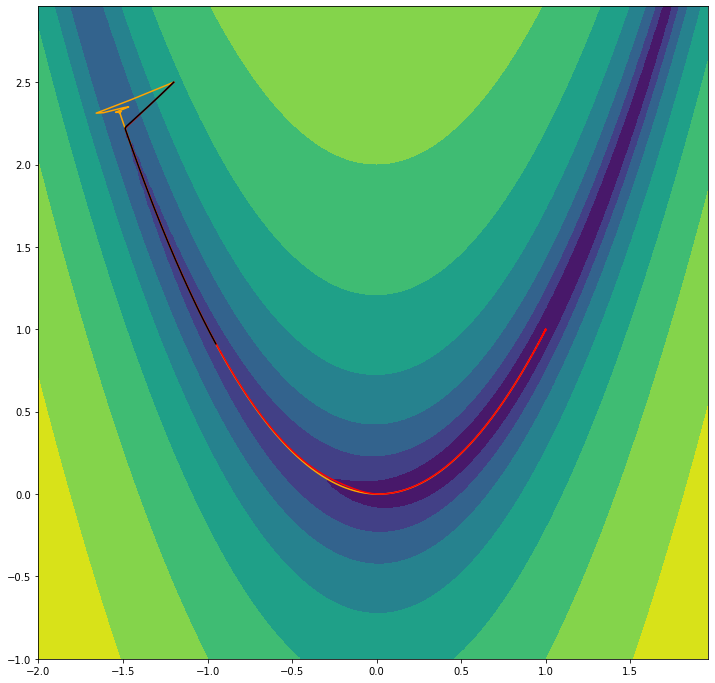

In [331]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.contourf(X,Y,z)
ax.plot(sgd_points[:,0].detach().numpy(), sgd_points[:,1].detach().numpy(), color='orange')
ax.plot(rms_points[:,0].detach().numpy(), rms_points[:,1].detach().numpy(), color='red')
ax.plot(adam_points[:,0].detach().numpy(), adam_points[:,1].detach().numpy(), color='black')